In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pattrex.plotting_mpl as plt_rex
import pattrex.preprocessing as pre_rex
import pattrex.fitting as fit_rex

from pattrex.demo_helper import read_whdata

In [3]:
# Read data, remove and save outliers
ws, hs, gs = read_whdata()
HW = np.vstack((hs, ws)).astype(np.float)
HW_new, neg_idx = pre_rex.only_all_positive(HW, True, return_neg_idx=True)
H_unknown = np.array([h for i, h in enumerate(hs) if i in neg_idx])



In [4]:
# fit normal distribution to height and weight
h_new = HW_new[0, :]
h_mean, h_std, _, _ = fit_rex.fit_normal_distribution(h_new)
w_new = HW_new[1, :]
w_mean, w_std, _, _ = fit_rex.fit_normal_distribution(w_new)

print("height: {}, {}, {}".format(h_mean, h_std, np.power(h_std, 2)))
print("weight: {}, {}, {}".format(w_mean, w_std, np.power(w_std, 2)))

height: 173.57142857142858, 7.241227392483947, 52.435374149659864
weight: 71.52380952380952, 14.45722441786392, 209.01133786848075


In [5]:
# Bi-variate Gaussian
print(np.mean(HW_new, axis=1))
print(np.var(HW_new, axis=1))
print(np.cov(HW_new))
np.cov(HW_new, ddof=0)

[ 173.57142857   71.52380952]
[  52.43537415  209.01133787]
[[  55.05714286   89.08571429]
 [  89.08571429  219.46190476]]


array([[  52.43537415,   84.84353741],
       [  84.84353741,  209.01133787]])

### effect of `ddof`

In [6]:
np.cov(h_new)

array(55.05714285714286)

In [7]:
x = [-2.1, -1,  4.3]
np.var(x)

7.8066666666666658

In [8]:
np.cov(x, ddof=0)

array(7.806666666666666)

In [9]:
np.mean(x)

0.39999999999999991

In [10]:
np.sum(np.power((x - np.mean(x)), 2) * (1/3))

7.8066666666666658

***

In [11]:
# Let us proceed with the default behaviour of 
bi_mean = np.mean(HW_new, axis=1)
bi_cov = np.cov(HW_new, ddof=0)

bi_sqrt = np.sqrt(bi_cov)
bi_std = np.array([bi_sqrt[0, 0], bi_sqrt[1, 1]])
bi_rho = bi_cov[0, 1]/(np.prod(bi_std))

print(bi_std)
bi_rho

[  7.24122739  14.45722442]


0.81044147676186351

In [12]:
np.corrcoef(HW_new)

array([[ 1.        ,  0.81044148],
       [ 0.81044148,  1.        ]])

### Calculate values for outliers

In [13]:
# ddof = 0
W_unknown = bi_mean[1] + bi_rho * (bi_std[1]/bi_std[0]) * (H_unknown - bi_mean[0])
W_unknown

array([ 62.50890849,  68.98114513,  60.89084933])

In [14]:
W_unknown = bi_mean[1] + bi_rho * (bi_std[1]/bi_std[0]) * (H_unknown - bi_mean[0])
W_unknown

array([ 62.50890849,  68.98114513,  60.89084933])

In [15]:
HW_new.shape

(2, 21)

In [16]:
mmi = HW_new.min(axis=1)
mmx = HW_new.max(axis=1)
mmi-mmx

array([-26., -45.])

## Meat and Potato

In [18]:
res = fit_rex.fit_multivariate_normal_dist(HW_new, X_unknown=H_unknown, X_unknown_dim=0)

In [19]:
_, _, W_pred, xypdf = res

In [20]:
W_pred

(array([ 168.,  172.,  167.]),
 array([ 62.50890849,  68.98114513,  60.89084933]))

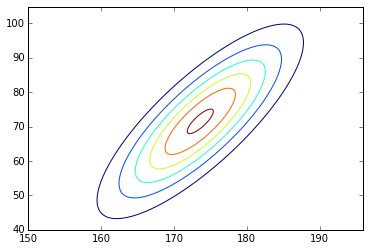

In [21]:
plt.contour(*xypdf)

### plotting

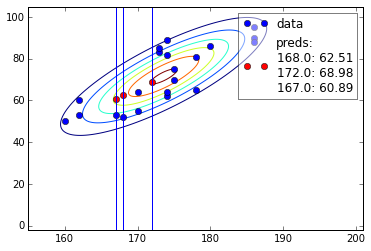

In [17]:
fig = plt.figure()
axs = fig.add_subplot(111)

# limits for the axes
HW_ = np.vstack((hs, ws))  # only the measurements; data is col-wise
xmin, ymin = HW_.min(axis=1)
xmax, ymax = HW_.max(axis=1)

xlim = [xmin-5, xmax+15]  # purely for looks
ylim = [-2, ymax+10]

plt_rex.plot2d(HW_new, colwise_data=True, hatch='bo', x_lim=xlim, 
               y_lim=ylim, show=False, axs=axs, plotlabel="data")

axs.contour(*xypdf)

plt_label = "preds:\n" + "\n".join("{}: {:.4}".format(*c) for c in \
                                   zip(H_unknown, W_pred))
plt_rex.plot2d(np.vstack((H_unknown, W_pred)), colwise_data=True, 
               hatch='ro', 
               show=False, axs=axs, plotlabel=plt_label)

for h in H_unknown:
    axs.axvline(x=h)

### dist of weights for predictions

In [20]:
from scipy.stats import multivariate_normal

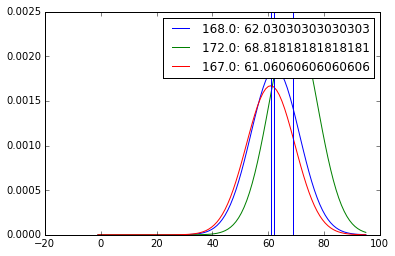

In [52]:
arg_max = []
for h in H_unknown:
    x = np.ones(100) * h
    y = np.linspace(ymin, ymax, 100)

    rv = multivariate_normal(res[0][0], res[0][1])
    pdf = rv.pdf(np.vstack((x, y)).T)
    plt.plot(y, pdf)
    arg_max.append(y[np.argmax(pdf)])

plt.legend(["{}: {}".format(*c) for c in zip(H_unknown, arg_max)])
for x in arg_max:
    plt.axvline(x=x)

In [55]:
xypdf[-1].shape

(213, 174)

In [57]:
xypdf[1].shape

(213, 174)

<IPython.core.display.Javascript object>


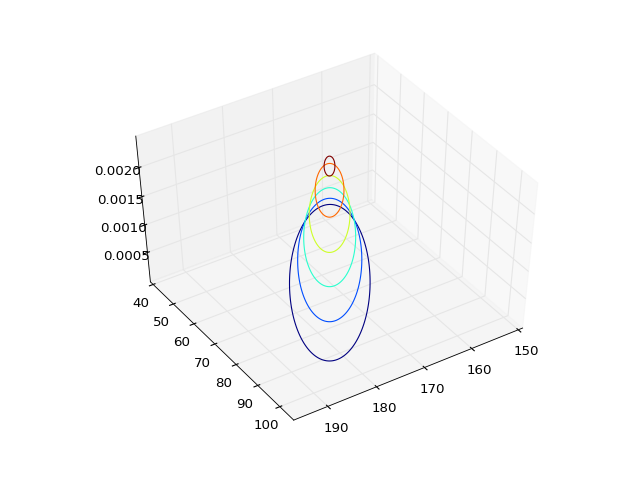

In [22]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour(*xypdf)